# K-means

```{note}
K-means 是最常见的聚类算法，它需要预先指定 number of clusters，遇到聚类问题可以先用它试试。
```

## K-means 算法

So, how does the algorithm work? 

Well, suppose you were given the centroids. You could easily label all the instances in the dataset by assigning each of them to the cluster **whose centroid is closest**.

Conversly, if you were given all the instance labels, you could easily locate all the centroids by computing **the mean of the instances for each cluster**.

But you are given neither the labels nor the centroids, so how can you proceed? Well, just start by placing the centroids randomly. Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving.

## K-means 算法的收敛性

K-means 算法可以保证收敛。定义 distortion function：

$$J(c, \mu) = \sum_{i=0}^{n}\| x^{(i)} - \mu_{c^{(i)}}\|^{2} $$

其中 $c^{(i)}$ 是 $x^{(i)}$ 所在的簇，$\mu_{c^{(i)}}$ 是 $x^{(i)}$ 所在簇的簇中心。

K-Means is exactly coordinate descent on $J$:

* label instances 阶段固定簇中心，调整样本所在的簇最小化 $J(c, \mu)$

* update centroids 阶段固定样本所在的簇，调整簇中心最小化 $J(c, \mu)$

$J(c, \mu)$ monotony decrease with lower bound, thus convergence. 事实上，只要某次 update centroids 阶段 $J(c, \mu)$ 不下降，K-means 算法就收敛了。

收敛后，$J(c, \mu)$ 等于 K-means 算法的重要指标 inertia，which is the mean squared distance between each instance and its closest centroid:

$$\sum_{i=0}^{n}\min_{\mu_{j}\in C}(\| x^{(i)} - \mu_{j}\|^{2})$$

## 使用方法

In [1]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
# 需要指定簇的个数
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [2]:
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

In [3]:
kmeans.predict([[0, 0], [12, 3]])

array([1, 0], dtype=int32)

In [4]:
# init: 如果你知道簇中心大概在哪，就手动设置之
# n_init: Number of times the k-means algorithm will be run with different centroid seeds, choose by inertia.
KMeans(n_clusters=5, 
       init=np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]]), 
       n_init=3)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=3)

## 如何确定簇的个数

首先看 inertia，越小越好。

In [5]:
# select k that is the elbow
kmeans.inertia_

16.0

另一个指标是 sihouette score, which is equal to:

$$\frac{b - a}{max(a, b)}$$

其中 a 是同一簇中点的平均距离，b 是点到本簇外最近点的平均距离。它的取值范围是 $(-1, 1)$，越大越好。

In [6]:
from sklearn.metrics import silhouette_score

# select k that maximize silhouette
silhouette_score(X, kmeans.labels_)

0.7133477791749615

## Some unintuitive or unexpected clusters

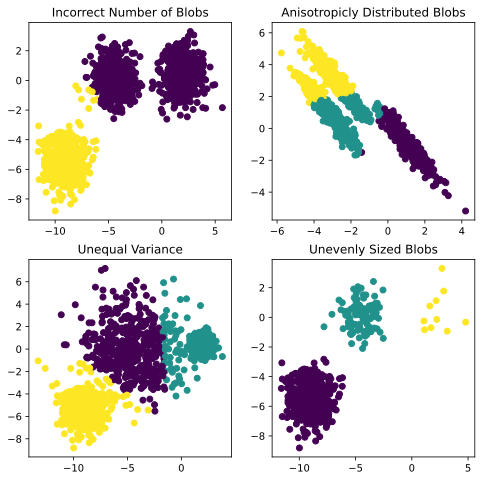

In [7]:
# Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(8, 8))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)
plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

## K-means++

K-means 算法会收敛，但可能收敛到的是 local minimal，结果高度依赖于簇中心的初始化。

One method to help address this issue is the k-means++ initiazation schema. This initiazes the **centroids to be distant from each other**, leading to probably better results than random initiazation.

它先随机选取一个点作为初始的簇中心；当簇中心数量小于 k 时，计算每个点与当前已有的簇中心的最短距离，这个值越大，表示被选取为下一个簇中心的概率越大。

In [8]:
# 设置 init='k-means++'
KMeans(n_clusters=3, init='k-means++')

KMeans(n_clusters=3)

## Minibatch K-Means

如果数据量大，其实每一步可以不用全部数据的，用 mini-batch 就很好了。

In [9]:
"""
minibatch k-means is capable of using mini-batches,
moving the centroids just slightly at each iteration,
this speed up cluster & enable clustering huge datasets.
"""
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)